### Introduction to TorchPhysics

This notebook contains a template for the joint exercise regarding physics informed deep learning and TorchPhysics.

We start by solving the Laplace equation:

\begin{align*}
    \Delta u &= 1 &&\text{ in } \Omega \\
    u &= 0 , &&\text{ on } \partial \Omega
\end{align*}

with $\Omega = (0, 1) \times (0, 1)$.

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
if user <= 21: 
    gpu_device = str(user % 7) # moriarty
else: gpu_device = str(user % 4) # neptuno
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

Next we implement the *Spaces* that appear in the problem:

In [2]:
import torch
import torchphysics as tp
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')

Now we define our domain, the unit square:

In [3]:
omega = tp.domains.Parallelogram(X, [0,0], [1,0], [0,1])

For the training we need to create some points, this is handle by the *Sampler*:

In [4]:
inner_sampler = tp.samplers.RandomUniformSampler(omega, n_points=15000)

boundary_sampler = tp.samplers.GridSampler(omega.boundary, n_points=5000)

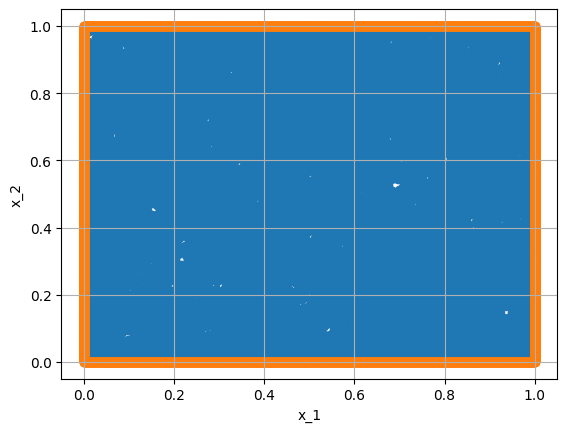

In [5]:
fig = tp.utils.scatter(X, inner_sampler, boundary_sampler)

We need a neural network that should learn our solution:

In [6]:
model = tp.models.FCN(input_space=X, output_space=U, hidden=(20,20,20))

Now, we have to transform out mathematical conditions given by our PDE into corresponding training conditions. First for the differential equation itself:

In [7]:
def pde_residual(u, x):
    return tp.utils.laplacian(u, x) - 1.0

pde_cond = tp.conditions.PINNCondition(model, inner_sampler, pde_residual)

Next for the boundary condition:

In [8]:
def boundary_residual(u, x):
    return u - 0.0

boundary_cond = tp.conditions.PINNCondition(model, boundary_sampler, boundary_residual, weight=50.0)

Before the training we collect all conditions and choose our training procedure:

In [9]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([boundary_cond, pde_cond], optimizer_setting=optim)

Start the training:

In [13]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator="gpu", # use one GPU
                     max_steps=6000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False) # saving checkpoints
trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 921    | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 6000/6000 [02:30<00:00, 39.85it/s, train/loss=4.9e-5]  

`Trainer.fit` stopped: `max_steps=6000` reached.


Epoch 0: 100%|██████████| 6000/6000 [02:30<00:00, 39.84it/s, train/loss=4.9e-5]


Lastly, we can plot the solution:

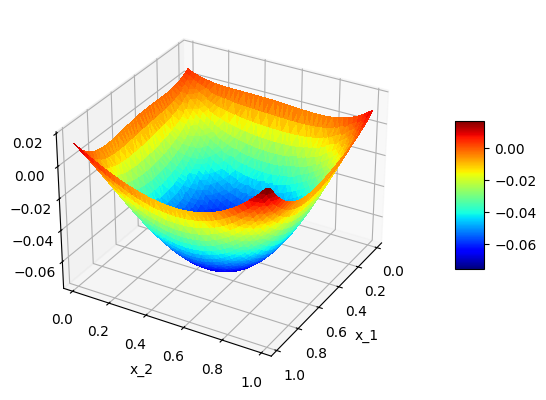

In [14]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=omega,
                                       n_points=2000)
fig = tp.utils.plot(model, lambda u : u, plot_sampler)

And compare PINNs with the FEM-solution:

In [ ]:
import numpy as np

# Read data:
coords = torch.tensor(np.load("/localdata/tomfre/SolutionData/LaplaceData/coordinates.npy"), dtype=torch.float32)
fem_sol = torch.tensor(np.load("/localdata/tomfre/SolutionData/LaplaceData/solution.npy"), dtype=torch.float32).reshape(-1, 1)

# Evaluate Network:
model_out = model(tp.spaces.Points(coords, X)).as_tensor

print("Difference to FEM in Sup-norm:")
difference_sup = torch.max(torch.abs(fem_sol - model_out))
print("Absolute:", difference_sup)
print("Relative:", difference_sup / torch.max(torch.abs(fem_sol)))